In [1]:
import torch 
import pandas as pd 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import datasets, transforms 
import matplotlib.pyplot as plt 

In [2]:
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')

print(DEVICE, '\t', 'torch : ', torch.__version__)

cuda 	 torch :  1.12.0


In [3]:
BATCH_SIZE = 128
EPOCHS = 100

In [4]:
train_dataset = datasets.MNIST(root='../../data/MNIST',
                                download=True,
                                train = True,
                                transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root='../../data/MNIST',
                                download=True,
                                train = False,
                                transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           shuffle=True,
                                           batch_size = BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                           shuffle=False,
                                           batch_size = BATCH_SIZE)

In [5]:
for (X_train, y_train) in train_loader : 
    print(X_train.size(), y_train.size())
    print(X_train.type(), y_train.type())
    break

torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.FloatTensor torch.LongTensor


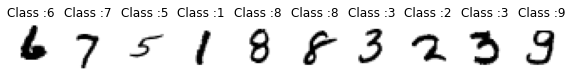

In [6]:
pltsize = 1
plt.figure(figsize = (pltsize * 10, pltsize))

for i in range(10) :
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = 'gray_r')
    plt.title('Class :' + str(y_train[i].item()))
plt.show()

In [24]:
class Net(nn.Module) :
    def __init__(self) :
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.GRU(input_size = 128, hidden_size = 256, dropout = 0.25)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x) :
        x = x.reshape(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x, _ = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

In [25]:
del model

In [26]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): GRU(128, 256, dropout=0.25)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [27]:
def train(model, train_loader, optimizer, log_intervals = 100) :
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader) :
        image = image.to(DEVICE) 
        label = label.to(DEVICE)
        output = model(image)
        optimizer.zero_grad()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_intervals == 0 :
            print('Train_Epoch : {}, [{} / {}]({:.0f}%)\tTrain_Loss : {:.6f}'.format(
                Epoch, batch_idx * len(image), len(train_loader.dataset),
                batch_idx * 100 / len(train_loader), loss.item()
            ))

In [28]:
def evaluate(model, test_loader) :
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad() :
        for image, label in test_loader :
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss = criterion(output, label)
            # max의 결과값으로 값, 인덱스가 나오므로 첫번쨰 값 사용
            # max안의 1은 어떤 방향의 값을 찾을지 설정
            prediction = output.max(1, keepdim = True)[1]
            # pred.eq(data)는 pred배열과 data가 일치하느냐를 검사
            # view_as 이용해서 shape 맞춰준듯
            correct += prediction.eq(label.view_as(prediction)).sum().item()
        test_loss = test_loss / len(test_loader) 
        test_accuracy = correct * 100 / len(test_loader.dataset)
        return test_loss, test_accuracy

In [29]:
best_accuracy = 0
es = 0
for Epoch in range(1, EPOCHS + 1) :
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print('\nEPOCH : {}, Test_loss : {:.4f} \t Test_accuracy : {:.2f}%\n'.format(
        Epoch, test_loss, test_accuracy
    ))

    if test_accuracy > best_accuracy :
        best_accuracy = test_accuracy
        best_model = model
        es = 0

    else :
        es += 1

    if es >= 30 :
        break

Train_Epoch : 1, [0 / 60000](0%)	Train_Loss : 2.300160
Train_Epoch : 1, [12800 / 60000](21%)	Train_Loss : 0.257016
Train_Epoch : 1, [25600 / 60000](43%)	Train_Loss : 0.139574
Train_Epoch : 1, [38400 / 60000](64%)	Train_Loss : 0.187186
Train_Epoch : 1, [51200 / 60000](85%)	Train_Loss : 0.206257

EPOCH : 1, Test_loss : 0.0023 	 Test_accuracy : 95.25%

Train_Epoch : 2, [0 / 60000](0%)	Train_Loss : 0.204459
Train_Epoch : 2, [12800 / 60000](21%)	Train_Loss : 0.192504
Train_Epoch : 2, [25600 / 60000](43%)	Train_Loss : 0.132610
Train_Epoch : 2, [38400 / 60000](64%)	Train_Loss : 0.187996
Train_Epoch : 2, [51200 / 60000](85%)	Train_Loss : 0.116145

EPOCH : 2, Test_loss : 0.0002 	 Test_accuracy : 95.72%

Train_Epoch : 3, [0 / 60000](0%)	Train_Loss : 0.075934
Train_Epoch : 3, [12800 / 60000](21%)	Train_Loss : 0.038309
Train_Epoch : 3, [25600 / 60000](43%)	Train_Loss : 0.154245


KeyboardInterrupt: 